In [85]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train='/Users/shensakura/Desktop/gu/train'
test='/Users/shensakura/Desktop/gu/test1'

In [3]:
print(f'Number of training images: {len(os.listdir(train))}')
print(f'Number of test images: {len(os.listdir(test))}')

Number of training images: 25000
Number of test images: 12500


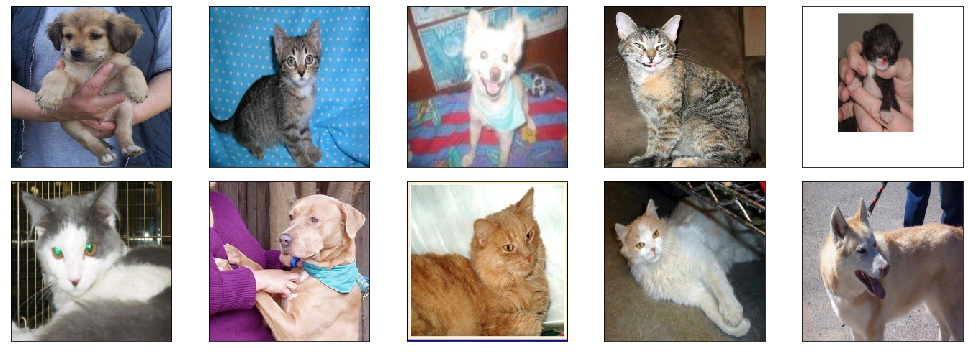

In [4]:
fig, axis = plt.subplots(2, 5, figsize = (14, 5))
for ax, file in zip(axis.flatten(), os.listdir(train)[:10]):
    img = cv2.imread(os.path.join(train, file))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()

In [5]:
# list of training files
train_files = os.listdir(train)
labels = []

for file in train_files:
    label = file.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)
        
train_df = pd.DataFrame({'file_names': train_files, 'labels': labels})
train_df['labels'] = train_df['labels'].replace({0: 'cat', 1: 'dog'})
train_df.head()

,file_names,labels
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [6]:
# split dataframe 
df_train, df_val = train_test_split(train_df, test_size = 0.2, stratify = train_df['labels'], random_state = 42)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [7]:
print(f'Shape of df_train: {df_train.shape}\nShape of df_val: {df_val.shape}')

Shape of df_train: (20000, 2)
Shape of df_val: (5000, 2)


In [8]:
img_size=(128,128)
batch_size=16

train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   horizontal_flip=True, 
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_dataframe(
                                    df_train, 
                                    train,
                                    x_col = 'file_names', 
                                    y_col = 'labels', 
                                    target_size=img_size,
                                    batch_size=batch_size,
                                    class_mode='binary')

val_generator=val_datagen.flow_from_dataframe(
                                    df_val, 
                                    train,
                                    x_col = 'file_names', 
                                    y_col = 'labels', 
                                    target_size=img_size,
                                    batch_size=batch_size,
                                    class_mode='binary')




Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
num_train_samples = train_generator.n
num_val_samples = val_generator.n

In [10]:
num_val_samples

5000

In [36]:
model_pretrained = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(128, 128, 3))

In [37]:
for layer in model_pretrained.layers:
  layer.trainable = False

last_layer = model_pretrained.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [38]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, Model

model = keras.Sequential([
    model_pretrained,
    layers.Flatten(),
    layers.Dense(1,activation='sigmoid')])         


model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [40]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [41]:
model_history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=num_train_samples//batch_size,
                              epochs=10,
                              validation_steps=num_val_samples//batch_size,
                              callbacks=[callback],
                              verbose=1)

Epoch 1/10
1250/1250 [==============================] - 271s 214ms/step - loss: 0.3318 - accuracy: 0.8626 - val_loss: 0.2632 - val_accuracy: 0.9077
Epoch 2/10
1250/1250 [==============================] - 279s 223ms/step - loss: 0.2586 - accuracy: 0.8939 - val_loss: 0.1974 - val_accuracy: 0.9289
Epoch 3/10
1250/1250 [==============================] - 279s 223ms/step - loss: 0.2444 - accuracy: 0.8992 - val_loss: 0.1636 - val_accuracy: 0.9373
Epoch 4/10
1250/1250 [==============================] - 273s 218ms/step - loss: 0.2434 - accuracy: 0.9008 - val_loss: 0.1707 - val_accuracy: 0.9357
Epoch 5/10
1250/1250 [==============================] - 272s 218ms/step - loss: 0.2335 - accuracy: 0.9025 - val_loss: 0.1766 - val_accuracy: 0.9329
Epoch 6/10
1250/1250 [==============================] - 266s 212ms/step - loss: 0.2357 - accuracy: 0.9028 - val_loss: 0.1541 - val_accuracy: 0.9377
Epoch 7/10
1250/1250 [==============================] - 258s 206ms/step - loss: 0.2213 - accuracy: 0.9097 - val_

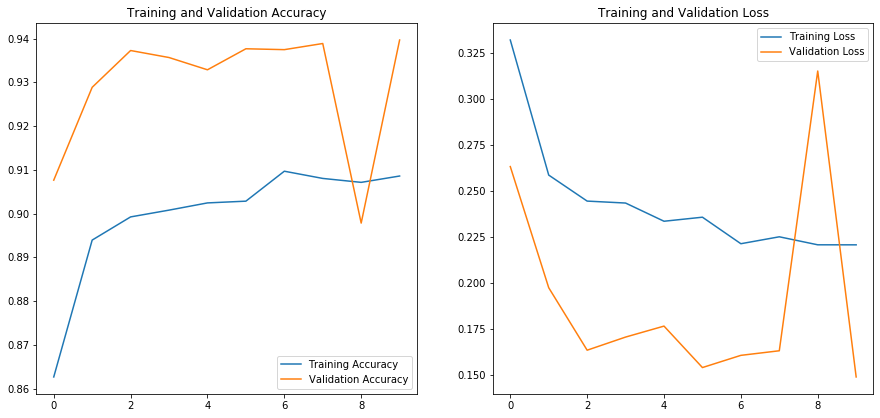

In [45]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [156]:
model_history.history

{'loss': [0.3318382203578949,
  0.25856104493141174,
  0.2444489747285843,
  0.24338911473751068,
  0.23351596295833588,
  0.2357109934091568,
  0.2213243842124939,
  0.22507919371128082,
  0.22073552012443542,
  0.22071735560894012],
 'accuracy': [0.8626499772071838,
  0.8939499855041504,
  0.8992499709129333,
  0.9007999897003174,
  0.9024500250816345,
  0.9028499722480774,
  0.9096999764442444,
  0.908050000667572,
  0.9071499705314636,
  0.9085999727249146],
 'val_loss': [0.2631775438785553,
  0.19744941592216492,
  0.16355815529823303,
  0.17067822813987732,
  0.17662936449050903,
  0.15413910150527954,
  0.160761758685112,
  0.16324645280838013,
  0.31501856446266174,
  0.14904281497001648],
 'val_accuracy': [0.9076522588729858,
  0.9288862347602844,
  0.9372996687889099,
  0.9356971383094788,
  0.9328926205635071,
  0.9377003312110901,
  0.9375,
  0.9389022588729858,
  0.8978365659713745,
  0.9397035241127014]}

In [157]:
#Accuracy and Loss of Validation Data
loss,accuracy = model.evaluate(val_generator,steps=num_val_samples//batch_size,verbose=1)
print("Validation Accuracy: ",accuracy)
print("Validation Loss: ",loss)

312/312 [==============================] - 36s 116ms/step - loss: 0.1493 - accuracy: 0.9395
Validation Accuracy:  0.9395031929016113
Validation Loss:  0.1492590457201004


In [70]:
def GetXY(gen):
    listX = []
    listY = []
    for i in range(gen.__len__()):
        gennext = gen.next()
        listX.append(gennext[0])
        listY.append(gennext[1])
    x=np.concatenate(listX)
    y=np.concatenate(listY)
    return (x,y)

In [72]:
testX, testY = GetXY(val_generator)

In [75]:
#Getting Predicted Value
y_pred = (model.predict(testX) > 0.5).astype("int32")

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2500
         1.0       0.95      0.93      0.94      2500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



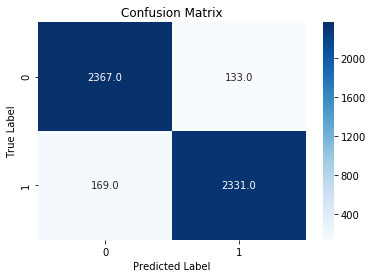

In [76]:
#Classification Report
print(classification_report(testY,y_pred))

#Confusion Matrix
confusion = confusion_matrix(testY, y_pred) 

sns.heatmap(confusion, annot=True,cmap="Blues",fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [98]:
# list of training files
test_files = os.listdir(test)

test_df = pd.DataFrame({'file_names':test_files})     
test_df.head()

,file_names
0,9733.jpg
1,63.jpg
2,6400.jpg
3,823.jpg
4,4217.jpg


In [99]:
#Test Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                test,
                                                class_mode=None,
                                                target_size=img_size,
                                                x_col="file_names",
                                                y_col=None,
                                                batch_size=batch_size)

Found 12500 validated image filenames.


In [100]:
#Visualize predicted resuls with images
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()

,index,file_names
0,924,2301.jpg
1,8180,720.jpg
2,7028,10362.jpg
3,213,10057.jpg
4,12124,999.jpg


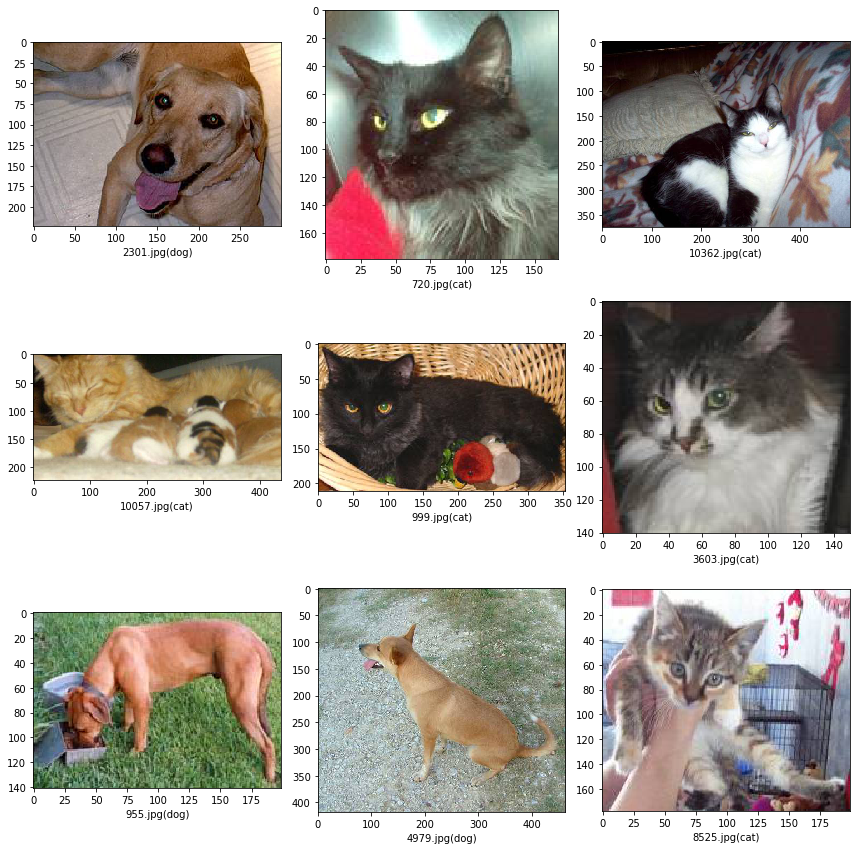

In [112]:
plt.figure(figsize=(12,12))
category_dict = {0: 'cat', 1: 'dog'}
for index, row in sample_test.iterrows():
    filename = row['file_names']
    img = load_img("/Users/shensakura/Desktop/gu/test1/"+filename)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    img = cv2.imread("/Users/shensakura/Desktop/gu/test1/"+filename)
    img = cv2.resize(img,(128,128))
    img = np.reshape(img,[1,128,128,3])
    img = img/255.0
    pred_prob = model.predict(img)[0][0]
    pred_cate = (pred_prob>0.5).astype("int32")
    category = category_dict[pred_cate]
    plt.xlabel(filename + '(' + category+ ')')
plt.tight_layout()
plt.show()

In [128]:
def cat_dog_identification(path, img_name):
    img = mpimg.imread(path+'/'+img_name)
    imgplot = plt.imshow(img)
    
    img = cv2.imread(path+'/'+img_name)
    img = cv2.resize(img,(128,128))
    img = np.reshape(img,[1,128,128,3])
    img = img/255.0
    pred_prob = model.predict(img)[0][0]
    pred_cate = (pred_prob>0.5).astype("int32")
    category = category_dict[pred_cate]
    plt.xlabel('(' + category+ ')')
    print(pred_prob)
    print(category)

In [115]:
path = "/Users/shensakura/Desktop/gu"

0.48079184
cat


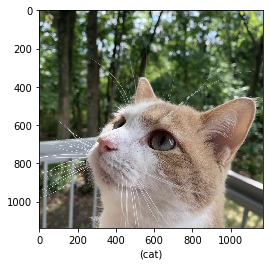

In [129]:
cat_dog_identification(path,'lingyi.jpg')

0.00011377103
cat


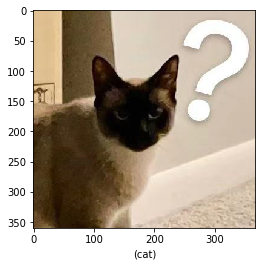

In [130]:
cat_dog_identification(path,'pinot.jpeg')

5.3091007e-05
cat


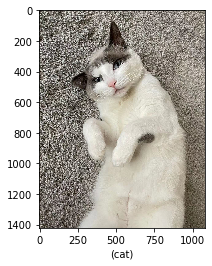

In [149]:
cat_dog_identification(path,'lucas.jpeg')

0.25590748
cat


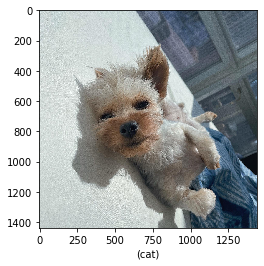

In [148]:
cat_dog_identification(path,'miko.jpeg')

0.78908396
dog


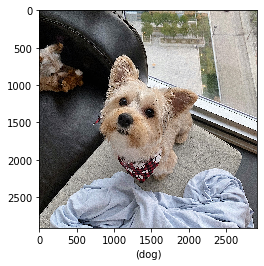

In [140]:
cat_dog_identification(path,'miko1.jpeg')

0.018652141
cat


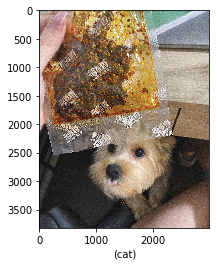

In [137]:
cat_dog_identification(path,'jerry.jpeg')

0.047937155
cat


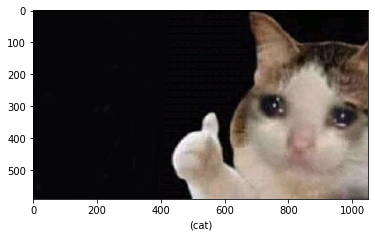

In [133]:
cat_dog_identification(path,'catmeme.jpeg')

0.33083984
cat


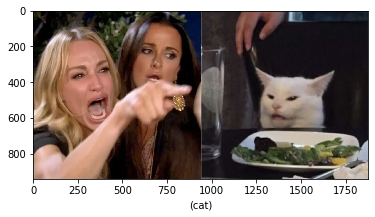

In [138]:
cat_dog_identification(path,'yelling.png')

0.99814236
dog


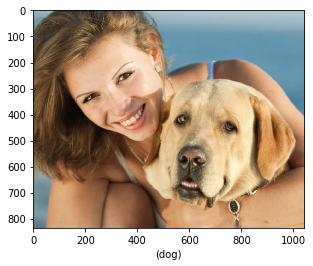

In [150]:
cat_dog_identification(path,'dognhuman.png')

0.13376158
cat


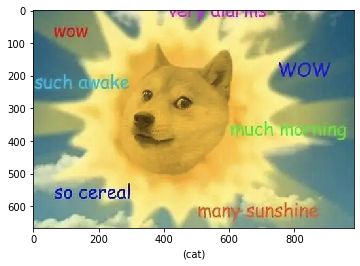

In [135]:
cat_dog_identification(path,'doge.png')

0.9778312
dog


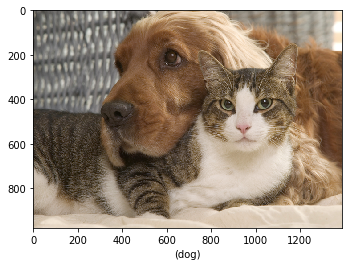

In [139]:
cat_dog_identification(path,'catndog.png')

0.043836325
cat


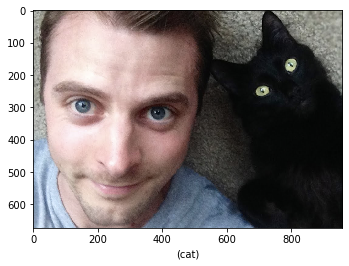

In [141]:
cat_dog_identification(path,'catnhuman.png')

0.7942436
dog


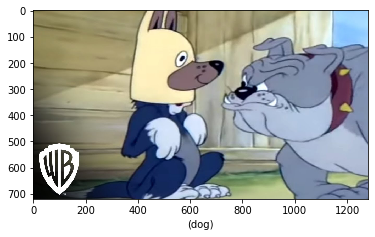

In [143]:
cat_dog_identification(path,'tom.jpeg')

1.2010789e-05
cat


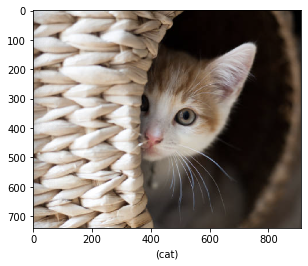

In [146]:
cat_dog_identification(path,'hiddenkit.png')

0.71184945
dog


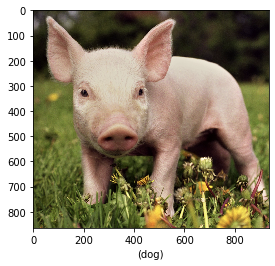

In [144]:
cat_dog_identification(path,'piggy.png')

0.80733955
dog


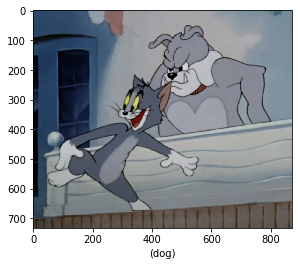

In [160]:
cat_dog_identification(path,'spiketom.png')